In [10]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
def load_images(source_dir):
    input_images = []
    output_labels = []

    channels = 1

    for image_path in glob.glob(source_dir + "/**/*.jpg", recursive=True):
        image_relative_path = image_path.replace(source_dir, '')
        relative_path_array = image_relative_path.split(os.path.sep)
        output_labels.append(relative_path_array[1])

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        resized = cv2.resize(img, (32, 32))
        resized = resized.reshape(32, 32, channels)
        input_images.append(resized/255)
        
    return input_images, output_labels

In [11]:
print('Start loading process')

source_dir = "/kaggle/input/asl-dataset-research/asl/asl_alphabet_train/asl_alphabet_train"
input_images, output_labels = load_images(source_dir)

print("End loading process")

Start loading process
End loading process


# Plotting Images

5


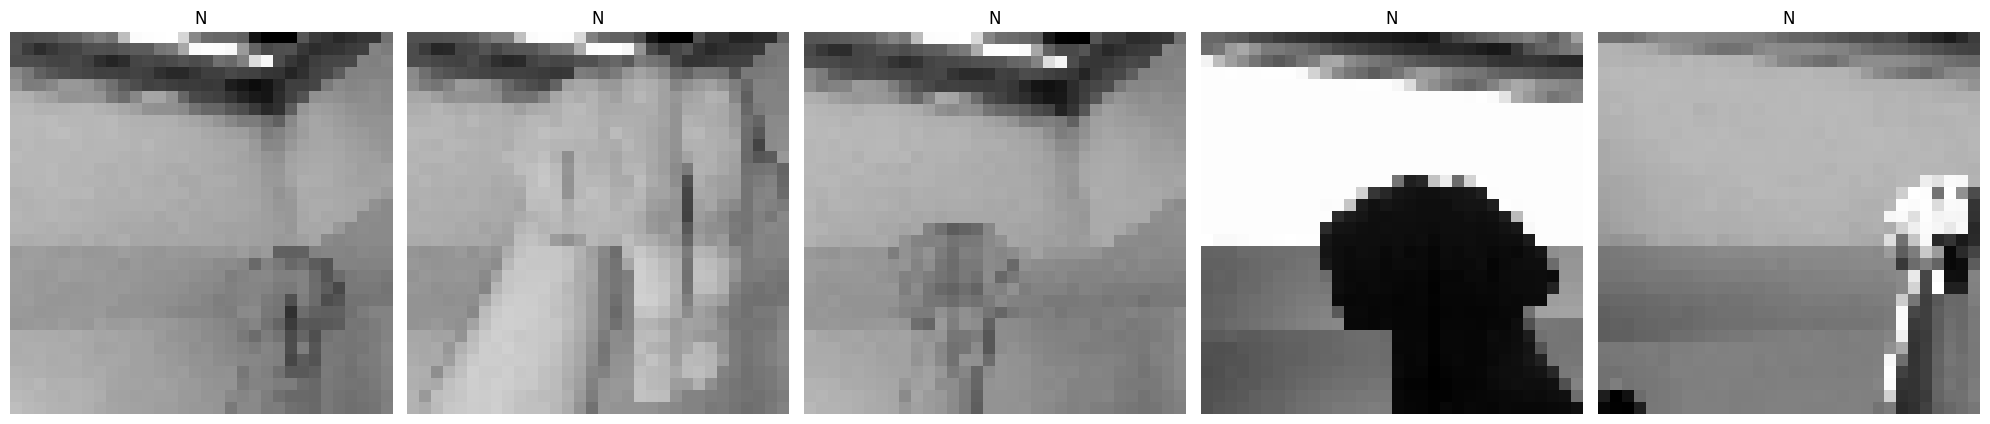

In [12]:
def plot_images(image_list, label_list, channels, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(20,20))
    axes = axes.flatten()

    for image, label, ax in zip(image_list, label_list, axes):
        if channels == 1:
            image = np.squeeze(image)

        ax.imshow(image, cmap='gray')
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print(len(input_images[:5]))

images_sample = [input_images[1], input_images[100], input_images[200], input_images[300], input_images[1000]]
labels_sample = [output_labels[1], output_labels[100], output_labels[200], output_labels[300], output_labels[1000]]

channels = 1
plot_images(images_sample, labels_sample, channels)

# Hot Encoded Labels

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
label_encoder.fit(output_labels)

labels_amount = len(label_encoder.classes_)

onehot_encoder = OneHotEncoder(sparse_output=False)

categorical_column = label_encoder.transform(output_labels)
integer_encoded = categorical_column.reshape(len(categorical_column),1)

onehot_encoder.fit(integer_encoded)
output_labels_values = onehot_encoder.transform(integer_encoded)

# Split

In [14]:
from sklearn.model_selection import train_test_split

images_train, images_test, labels_train, labels_test = train_test_split(input_images, output_labels_values, test_size=0.3, random_state=42)

print('Training set size : ', len(images_train))
print('Testing set size : ', len(images_test))
print('Labels set size : ', len(labels_train))
print('Labels testing set size : ', len(labels_test))

Training set size :  60900
Testing set size :  26100
Labels set size :  60900
Labels testing set size :  26100


In [19]:
import numpy as np
images_train_flat = np.array([image.flatten() for image in images_train])
images_test_flat = np.array([image.flatten() for image in images_test])
labels_train_flat = np.argmax(np.array(labels_train), axis=1)
labels_test_flat = np.argmax(np.array(labels_test), axis=1)

In [23]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Reshape the dataset to the required input shape
images_train_flat = images_train_flat.reshape(-1, 32, 32, 3)

# Normalize the images
images_train_flat = images_train_flat.astype('float32')
images_train_flat /= 255.0

# Convert labels to categorical
labels_train_flat = to_categorical(labels_train_flat, 29)

# CNN

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation

# Define the model
cnn_model = Sequential()

# Input Layer: 32x32 image with 3 channels (RGB)
cnn_model.add(Conv2D(8, (3, 3), input_shape=(32, 32, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 2: 16 filters of 3x3
cnn_model.add(Conv2D(16, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 3: 32 filters of 3x3
cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to fully connected layers
cnn_model.add(Flatten())

# Fully connected layer with 512 neurons
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))

# Output layer with 29 classes (corresponding to the alphabet hand signals)
cnn_model.add(Dense(29))
cnn_model.add(Activation('softmax'))

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
cnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 30, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 29)             │        14,877 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 29)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,957 (339.68 KB)

 Trainable params: 86,957 (339.68 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
"""from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

cnn_fitted = cnn_model.fit(images_train_flat, labels_train_flat, batch_size=32, 
                           epochs=10, verbose=1, 
                           validation_data=(images_test_flat, labels_test_flat))
cnn_predictions = cnn_fitted.predict(images_test_flat)
"""

print("images train : ",len(images_train_flat))
print("label train : ",len(labels_train_flat))
print("images test : ",len(images_test_flat))
print("label test : ",len(labels_test_flat))

images train :  20300
label train :  60900
images test :  26100
label test :  26100
